In [3]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
from __future__ import division
import os
import urllib, cStringIO

import pymongo as pm
from PIL import Image
import base64

import numpy as np
from numpy import *
import os
import PIL
from PIL import Image
import base64
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches


import cStringIO
import pandas as pd
import pymongo as pm ## first establish ssh tunnel to server where database is running
from matplotlib.path import Path
import matplotlib.patches as patches
from svgpathtools import parse_path

In [4]:
# directory & file hierarchy
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [40]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']


In [46]:
# wave 1 of data collection (16 classes)
experiment_name = 'cdm_run_v2'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
practice_categories = ['square','shape','circle']
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)

# wave 2 of data collection (22 classes) 
experiment_name = 'cdm_run_v3'
valid_sessions += coll2.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
print 'We currently have {} valid sessions, including {}.'.format(len(valid_sessions), experiment_name)

We currently have 512 valid sessions from cdm_run_v2.
We currently have 548 valid sessions, including cdm_run_v3.


In [48]:
image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    

#### helper functions for svg rendering

In [49]:
def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if len(verts)>0:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(0,500)
        ax.set_ylim(0,500) 
        ax.axis('off')
        plt.gca().invert_yaxis() # y values increase as you go down in image
        plt.show()
    else:
        ax.set_xlim(0,500)
        ax.set_ylim(0,500)        
        ax.axis('off')
        plt.show()
    plt.savefig()
    plt.close()
    
def flatten(x):
    return [val for sublist in x for val in sublist]

In [50]:
def get_verts_and_codes(svg_list):
    '''
    parse into x,y coordinates and output list of lists of coordinates
    
    '''    
    lines = []
    Verts = []
    Codes = []
    for stroke_ind,stroke in enumerate(svg_list):
        x = []
        y = []
        parsed = parse_path(stroke)
        for i,p in enumerate(parsed):
            if i!=len(parsed)-1: # last line segment
                x.append(p.start.real)
                y.append(p.start.imag)    
            else:
                x.append(p.start.real)
                y.append(p.start.imag)     
                x.append(p.end.real)
                y.append(p.end.imag)
        lines.append(zip(x,y))
        verts, codes = polyline_pathmaker(lines)
        Verts.append(verts)
        Codes.append(codes)                  
    return Verts, Codes
    
def make_svg_list(stroke_recs):
    '''
    grab sample drawing's strokes and make a list of svg strings from it
    '''
    svg_list = []
    for single_stroke in stroke_recs:
        svg_string = single_stroke['svg']
        svg_list.append(svg_string)  
        
    return svg_list
    
    
def render_and_save(Verts,
                    Codes,
                    line_width=5,
                    imsize=8,
                    canvas_size=600,
                    session_id=session_id,
                    age=age,
                    trial_num=trial_num,
                    category=category):
    
    '''
    input: 
        line_width: how wide of strokes do we want? (int)
        imsize: how big of a picture do we want? (setting the size of the figure) 
        canvas_size: original canvas size on tablet?
        out_path: where do you want to save your images? currently hardcoded below.        
    output:
        rendered sketches into nested directories
    
    '''
    ## where do you want to save your cumulative drawings?
    out_path = os.path.join('./cumulative_drawings','{}_{}'.format(session_id,age),'{}_{}'.format(trial_num,category))
    if not os.path.exists('./cumulative_drawings'):
        os.makedirs('./cumulative_drawings')
    if not os.path.exists(os.path.join('cumulative_drawings','{}_{}'.format(session_id,age))):
        os.makedirs(os.path.join('cumulative_drawings','{}_{}'.format(session_id,age)))

    verts = Verts[0]
    codes = Codes[0]
    for i,verts in enumerate(Verts):
        codes = Codes[i]
        fig = plt.figure(figsize=(imsize,imsize))    
        ax = plt.subplot(111)
        ax.axis('off')
        ax.set_xlim(0,canvas_size)
        ax.set_ylim(0,canvas_size)
        ### render sketch so far
        if len(verts)>0:
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=line_width)
            ax.add_patch(patch)
            plt.gca().invert_yaxis() # y values increase as you go down in image
            plt.show()
        else:        
            plt.show()  

        ## save out as png 
        ## maybe to make it not render every single thing, use plt.ioff
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fname = '{}_{}_{}_{}.png'.format(session_id,trial_num,category,i)
        filepath = os.path.join(out_path,fname)
        print filepath
        fig.savefig(filepath,bbox_inches='tight')
        plt.close(fig)        

In [ ]:
im

Great! Number of drawings made by this person: 8


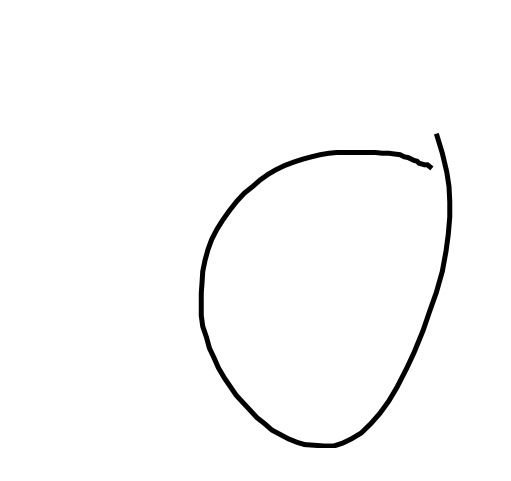

./cumulative_drawings/cdm_run_v31525887854758_age6/2_this circle/cdm_run_v31525887854758_2_this circle_0.png


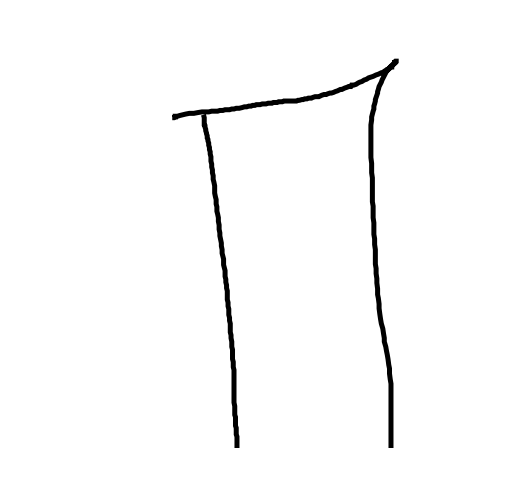

./cumulative_drawings/cdm_run_v31525887854758_age6/3_a cup/cdm_run_v31525887854758_3_a cup_0.png


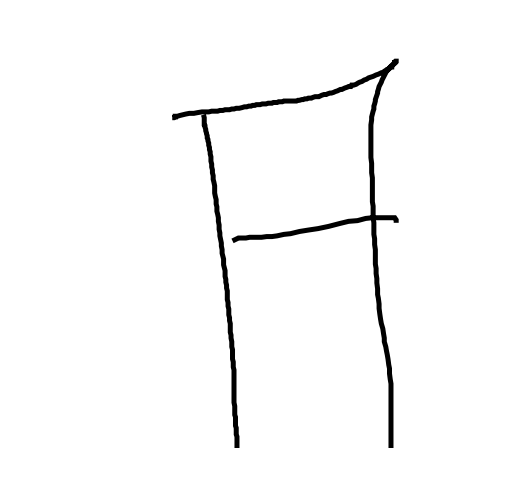

./cumulative_drawings/cdm_run_v31525887854758_age6/3_a cup/cdm_run_v31525887854758_3_a cup_1.png


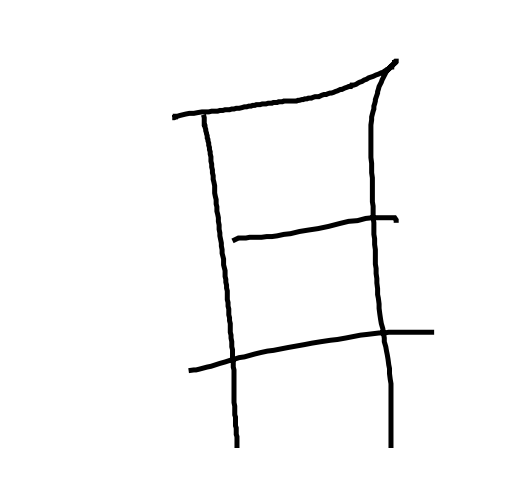

./cumulative_drawings/cdm_run_v31525887854758_age6/3_a cup/cdm_run_v31525887854758_3_a cup_2.png


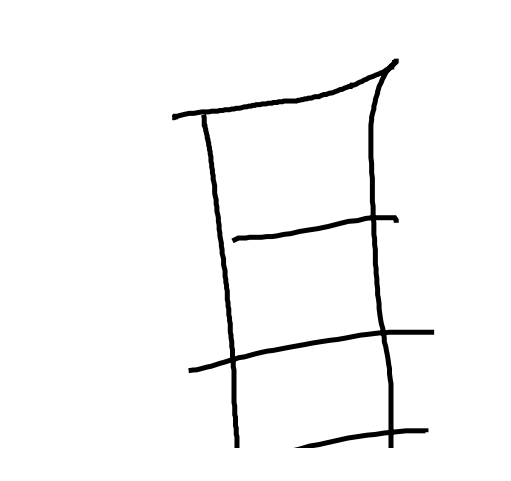

./cumulative_drawings/cdm_run_v31525887854758_age6/3_a cup/cdm_run_v31525887854758_3_a cup_3.png


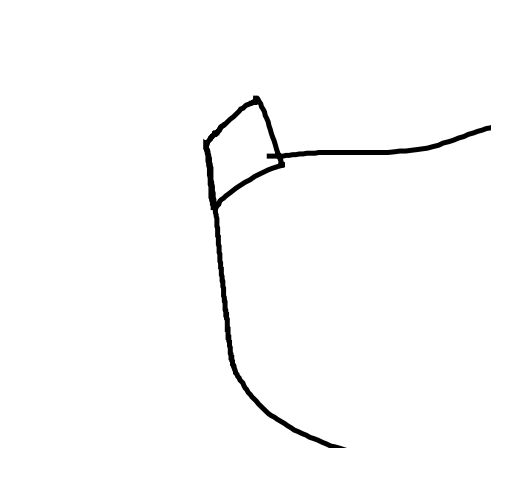

./cumulative_drawings/cdm_run_v31525887854758_age6/4_a tree/cdm_run_v31525887854758_4_a tree_0.png


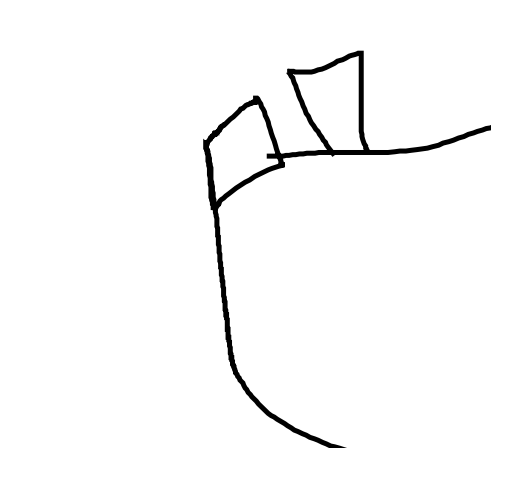

./cumulative_drawings/cdm_run_v31525887854758_age6/4_a tree/cdm_run_v31525887854758_4_a tree_1.png


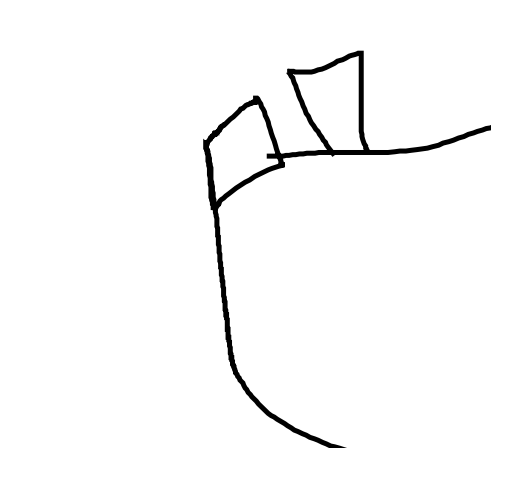

./cumulative_drawings/cdm_run_v31525887854758_age6/4_a tree/cdm_run_v31525887854758_4_a tree_2.png


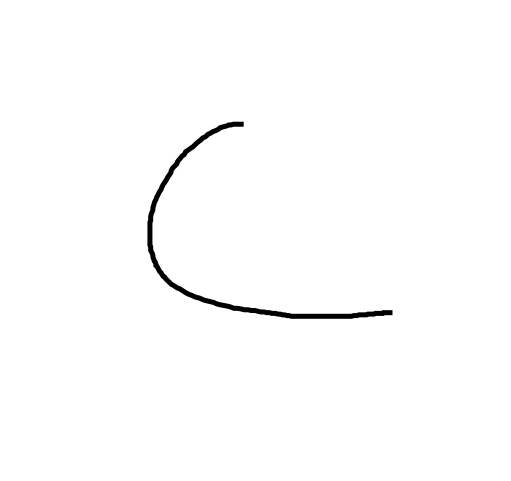

./cumulative_drawings/cdm_run_v31525887854758_age6/5_a fish/cdm_run_v31525887854758_5_a fish_0.png


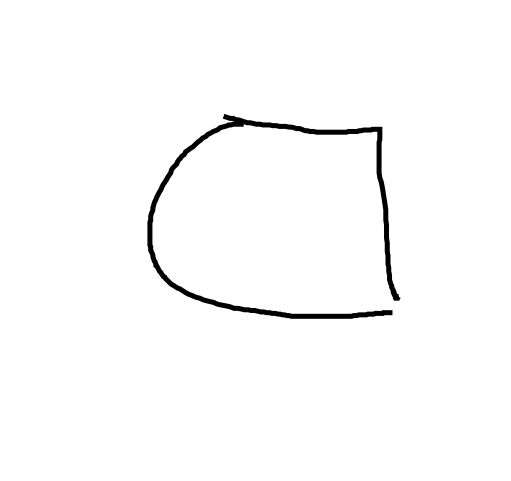

./cumulative_drawings/cdm_run_v31525887854758_age6/5_a fish/cdm_run_v31525887854758_5_a fish_1.png


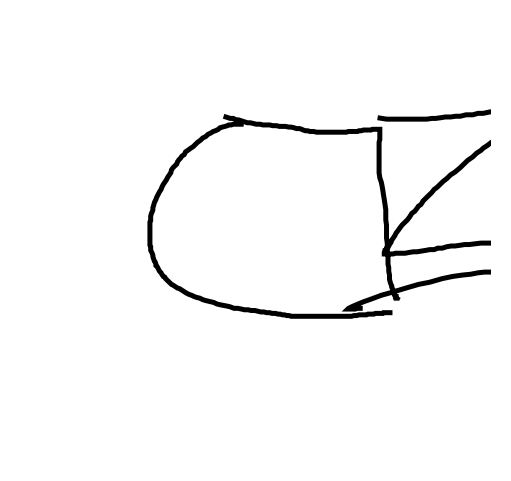

./cumulative_drawings/cdm_run_v31525887854758_age6/5_a fish/cdm_run_v31525887854758_5_a fish_2.png


InvalidOperation: cannot set options after executing query

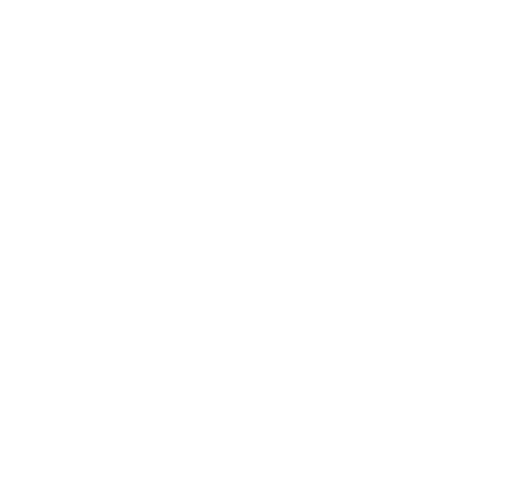

In [85]:
for i,s in enumerate(valid_sessions):    
    image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 3:
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
            for imrec in image_recs:         
                if imrec['category'] not in practice_categories: ## don't save practice category trials
                    stroke_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                      {'sessionId':s}, 
                                                      {'dataType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')  
                    ## check to make sure that there is at least one stroke! 
                    assert stroke_recs.count()>0

                    ## some handy metadata for writing out the sketch PNG filename
                    trial_num = stroke_recs[0]['trialNum']
                    category = stroke_recs[0]['category']
                    session_id = stroke_recs[0]['sessionId']
                    age = stroke_recs[0]['age']

                    ## now make an svg list!
                    svg_list = make_svg_list(stroke_recs)

                    ## now get me some verts and codes!
                    Verts, Codes = get_verts_and_codes(svg_list)

                    ## now render out your cumulative sketches and save out as pngs!
                    render_and_save(Verts,
                                    Codes,
                                    line_width=5,
                                    imsize=8,
                                    canvas_size=600,
                                    session_id=session_id,
                                    age=age,
                                    trial_num=trial_num,
                                    category=category)

        except:
            print 'Oops, something went wrong! Maybe an empty sketch? See {}'      
